# Apple Stock Price Prediction and Forecasting using LSTM Neural Network

In [3]:
import tensorflow as tf
tf.__version__

'2.1.0'

### Data collection

In [4]:
import pandas_datareader as pdr
import os

In [5]:
%reload_ext dotenv
%dotenv

In [6]:
df = pdr.get_data_tiingo('AAPL', api_key=os.getenv('TIINGO_API_KEY'))

In [7]:
df.to_csv("aapl.csv")

In [8]:
import pandas as pd

In [9]:
aapl = pd.read_csv("aapl.csv")

In [10]:
aapl.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-01-11 00:00:00+00:00,98.53,99.06,97.3400,98.97,49739377,22.818423,22.941165,22.542833,22.920322,198957508,0.0,1.0
1,AAPL,2016-01-12 00:00:00+00:00,99.96,100.69,98.8399,100.55,49154227,23.149595,23.318654,22.890192,23.286232,196616908,0.0,1.0
2,AAPL,2016-01-13 00:00:00+00:00,97.39,101.19,97.3000,100.32,62439631,22.554412,23.434449,22.533569,23.232967,249758524,0.0,1.0
3,AAPL,2016-01-14 00:00:00+00:00,99.52,100.48,95.7400,97.96,63170127,23.047696,23.270021,22.172291,22.686417,252680508,0.0,1.0
4,AAPL,2016-01-15 00:00:00+00:00,97.13,97.71,95.3600,96.20,79833891,22.494199,22.628520,22.084287,22.278822,319335564,0.0,1.0


In [11]:
aapl.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1254,AAPL,2021-01-04 00:00:00+00:00,129.41,133.6116,126.760,133.52,143301887,129.41,133.6116,126.760,133.52,143301887,0.0,1.0
1255,AAPL,2021-01-05 00:00:00+00:00,131.01,131.7400,128.430,128.89,97664898,131.01,131.7400,128.430,128.89,97664898,0.0,1.0
1256,AAPL,2021-01-06 00:00:00+00:00,126.60,131.0499,126.382,127.72,155087970,126.60,131.0499,126.382,127.72,155087970,0.0,1.0
1257,AAPL,2021-01-07 00:00:00+00:00,130.92,131.6300,127.860,128.36,109578157,130.92,131.6300,127.860,128.36,109578157,0.0,1.0
1258,AAPL,2021-01-08 00:00:00+00:00,132.05,132.6300,130.230,132.43,105158245,132.05,132.6300,130.230,132.43,105158245,0.0,1.0


In [12]:
aapl["close"].describe()

count    1259.000000
mean      182.673928
std        75.620351
min        90.340000
25%       120.040000
50%       170.410000
75%       209.435000
max       506.090000
Name: close, dtype: float64

In [13]:
df = aapl["close"]

In [14]:
df.shape

(1259,)

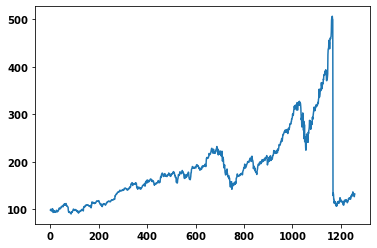

In [15]:
import matplotlib.pyplot as plt

plt.plot(df)

### Data Preprocessing

#### LSTM are sensitive to the scale of the data. We will apply MinMax Scaler

In [16]:
import numpy as np

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [18]:
df

array([[0.01969934],
       [0.02313891],
       [0.01695731],
       ...,
       [0.08721587],
       [0.09760673],
       [0.10032471]])

#### For timeseries data train test split performed by date (because tomorrow's day can be dependent on today's day, and today's day is dependent on yesterday's day)

In [19]:
training_size = int(len(df)*0.7)
test_size = len(df) - training_size
train, test = df[0:training_size,:], df[training_size:len(df), :1]

In [20]:
train.shape, test.shape

((881, 1), (378, 1))

In [21]:
# convert array of values into dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)
    

In [22]:
time_step = 100
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [23]:
X_train.shape, X_test.shape

((780, 100), (277, 100))

### Create LSTM model

#### Reshape data in 3 dimentions for LSTM (requirement) [samples, time_step, features]

In [24]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [25]:
### Create LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [26]:
# create stacked LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Train on 780 samples, validate on 277 samples
Epoch 1/100
780/780 [==============================] - 5s 6ms/sample - loss: 0.0095 - val_loss: 0.0633
Epoch 2/100
780/780 [==============================] - 0s 526us/sample - loss: 0.0020 - val_loss: 0.0300
Epoch 3/100
780/780 [==============================] - 0s 477us/sample - loss: 6.7105e-04 - val_loss: 0.0273
Epoch 4/100
780/780 [==============================] - 0s 460us/sample - loss: 4.7502e-04 - val_loss: 0.0267
Epoch 5/100
780/780 [==============================] - 0s 471us/sample - loss: 4.3492e-04 - val_loss: 0.0242
Epoch 6/100
780/780 [==============================] - 0s 470us/sample - loss: 4.1273e-04 - val_loss: 0.0236
Epoch 7/100
780/780 [==============================] - 0s 477us/sample - loss: 3.8892e-04 - val_loss: 0.0230
Epoch 8/100
780/780 [==============================] - 0s 520us/sample - loss: 3.6558e-04 - val_loss: 0.0223
Epoch 9/100
780/780 [==============================] - 0s 504us/sample - loss: 3.4389e-04 - 

In [29]:
# Let's do the predict train and test
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [30]:
# transform back the data to it's original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [31]:
# Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_train, train_predict))

165.19399243313273

In [32]:
# Test data RMSE
np.sqrt(mean_squared_error(y_test, test_predict))

281.38316512519566

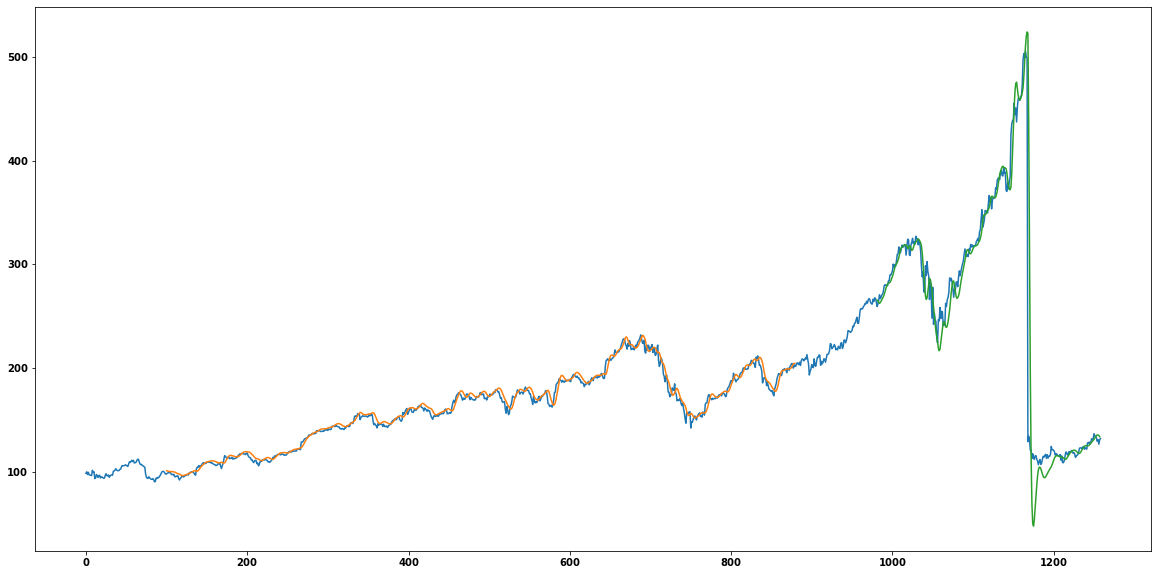

In [33]:
# shift train prediction for ploting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[100:len(train_predict)+100, :] = train_predict

# shift test prediction for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(100*2)+1:len(df)-1, :] = test_predict

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Predict future 30 days

In [34]:
len(test)

378

In [35]:
# take last 100 days from test data
x_input = test[278:].reshape(1,-1)

In [36]:
x_input.shape

(1, 100)

In [37]:
x_input

array([[0.89455201, 0.89594708, 0.92064943, 0.97929044, 0.99360192,
        0.98366807, 1.        , 0.98544799, 0.9834997 , 0.09308479,
        0.10544799, 0.09876127, 0.07345761, 0.07365003, 0.05407096,
        0.06489477, 0.0556825 , 0.05209862, 0.06016837, 0.06061335,
        0.0524113 , 0.04810583, 0.03968731, 0.04748046, 0.05164161,
        0.04036079, 0.04300661, 0.0527721 , 0.05921828, 0.05712568,
        0.06126278, 0.06361996, 0.05455201, 0.06292243, 0.05488876,
        0.05950692, 0.05924233, 0.06405292, 0.08192423, 0.07398677,
        0.07420325, 0.07304871, 0.06898376, 0.06167168, 0.06535177,
        0.06381239, 0.06111846, 0.0594107 , 0.05943476, 0.06316296,
        0.05017438, 0.06008419, 0.044546  , 0.04432952, 0.04834636,
        0.05919423, 0.06900782, 0.06819002, 0.06248948, 0.06164762,
        0.07011425, 0.06944077, 0.06956103, 0.07206254, 0.06987372,
        0.06660253, 0.06806975, 0.06494287, 0.05654841, 0.05972339,
        0.06179194, 0.06313891, 0.06905592, 0.07

In [38]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [39]:
temp_input

[0.89455201443175,
 0.8959470835838845,
 0.9206494287432352,
 0.9792904389657247,
 0.9936019242333134,
 0.9836680697534577,
 1.0,
 0.9854479855682503,
 0.983499699338545,
 0.09308478653036678,
 0.10544798556825014,
 0.09876127480457003,
 0.07345760673481655,
 0.07365003006614551,
 0.05407095610342749,
 0.06489476849067943,
 0.055682501503307225,
 0.052098616957306054,
 0.0601683704149128,
 0.06061334936861096,
 0.05241130487071555,
 0.04810583283223091,
 0.03968731208659049,
 0.04748045700541187,
 0.05164161154539987,
 0.04036079374624174,
 0.04300661455201443,
 0.05277209861695731,
 0.05921828021647624,
 0.05712567648827421,
 0.06126277811184605,
 0.06361996392062536,
 0.05455201443174984,
 0.062922429344558,
 0.05488875526157544,
 0.059506915213469624,
 0.059242333132892344,
 0.06405291641611544,
 0.08192423331328924,
 0.07398677089597111,
 0.07420324714371618,
 0.07304870715574258,
 0.06898376428141911,
 0.061671677690920024,
 0.06535177390258567,
 0.06381238725195432,
 0.0611184606

In [40]:
# prediction for the next 30 days

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.10078996]
1 day input [0.89594708 0.92064943 0.97929044 0.99360192 0.98366807 1.
 0.98544799 0.9834997  0.09308479 0.10544799 0.09876127 0.07345761
 0.07365003 0.05407096 0.06489477 0.0556825  0.05209862 0.06016837
 0.06061335 0.0524113  0.04810583 0.03968731 0.04748046 0.05164161
 0.04036079 0.04300661 0.0527721  0.05921828 0.05712568 0.06126278
 0.06361996 0.05455201 0.06292243 0.05488876 0.05950692 0.05924233
 0.06405292 0.08192423 0.07398677 0.07420325 0.07304871 0.06898376
 0.06167168 0.06535177 0.06381239 0.06111846 0.0594107  0.05943476
 0.06316296 0.05017438 0.06008419 0.044546   0.04432952 0.04834636
 0.05919423 0.06900782 0.06819002 0.06248948 0.06164762 0.07011425
 0.06944077 0.06956103 0.07206254 0.06987372 0.06660253 0.06806975
 0.06494287 0.05654841 0.05972339 0.06179194 0.06313891 0.06905592
 0.07788334 0.07874925 0.07841251 0.07675286 0.08036079 0.08187613
 0.07562237 0.0791341  0.0771377  0.07562237 0.09029465 0.09012628
 0.09226699 0.08734817 0.0911365  0.09991581 

In [41]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [42]:
len(df)

1259

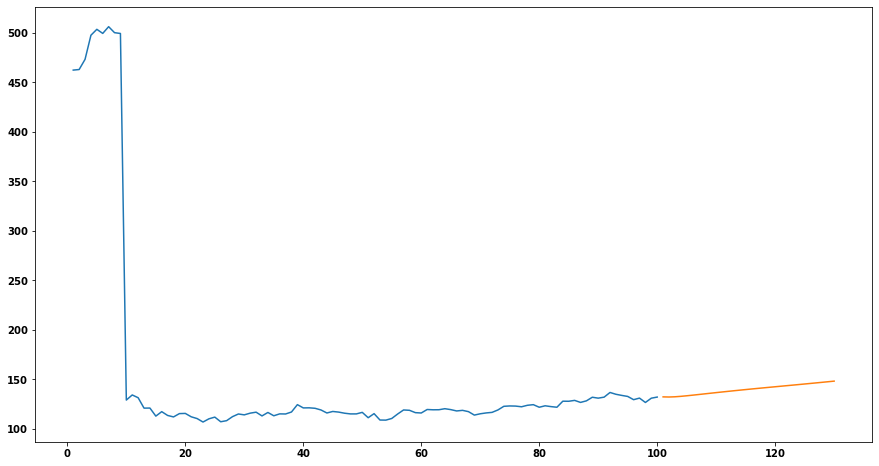

In [43]:
plt.figure(figsize=(15,8))
plt.plot(day_new,scaler.inverse_transform(df[1159:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

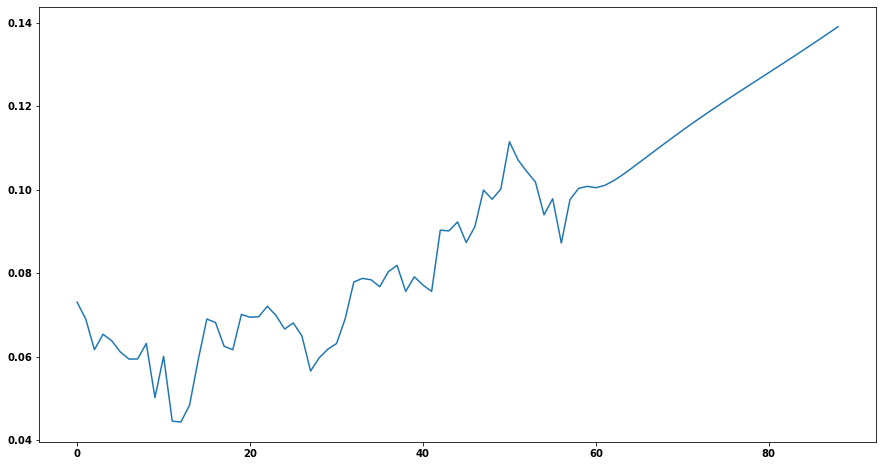

In [44]:
# Combine predicted with true data

df2=df.tolist()
df2.extend(lst_output)
plt.figure(figsize=(15,8))
plt.plot(df2[1200:])

### We can say that price slowly and gradually going up after a major drop in 2020 due to shutdown

In [45]:
### Increase time step

time_step = 200
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [46]:
X_train.shape, X_test.shape

((680, 200), (177, 200))

In [47]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [85]:
# create stacked LSTM model
model2 = Sequential()
model2.add(LSTM(100, return_sequences=True, input_shape=(200,1)))
model2.add(LSTM(100, return_sequences=True))
model2.add(LSTM(50))
model2.add(Dense(1))
model2.compile(loss="mean_squared_error", optimizer="adam")

In [86]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 200, 100)          40800     
_________________________________________________________________
lstm_7 (LSTM)                (None, 200, 100)          80400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 151,451
Trainable params: 151,451
Non-trainable params: 0
_________________________________________________________________


In [87]:
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Train on 680 samples, validate on 177 samples
Epoch 1/100
680/680 [==============================] - 3s 4ms/sample - loss: 0.0082 - val_loss: 0.0634
Epoch 2/100
680/680 [==============================] - 1s 743us/sample - loss: 0.0015 - val_loss: 0.0485
Epoch 3/100
680/680 [==============================] - 1s 773us/sample - loss: 9.2070e-04 - val_loss: 0.0355
Epoch 4/100
680/680 [==============================] - 1s 748us/sample - loss: 5.7587e-04 - val_loss: 0.0343
Epoch 5/100
680/680 [==============================] - 1s 789us/sample - loss: 4.2094e-04 - val_loss: 0.0344
Epoch 6/100
680/680 [==============================] - 1s 775us/sample - loss: 4.0026e-04 - val_loss: 0.0332
Epoch 7/100
680/680 [==============================] - 1s 777us/sample - loss: 3.6882e-04 - val_loss: 0.0316
Epoch 8/100
680/680 [==============================] - 1s 756us/sample - loss: 3.4973e-04 - val_loss: 0.0309
Epoch 9/100
680/680 [==============================] - 1s 754us/sample - loss: 3.3679e-04 - 

In [88]:
# Let's do the predict train and test
train_predict = model2.predict(X_train)
test_predict = model2.predict(X_test)

In [89]:
# transform back the data to it's original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [90]:
# Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_train, train_predict))

171.11732500388544

In [91]:
# Test data RMSE
np.sqrt(mean_squared_error(y_test, test_predict))

249.19731656544323

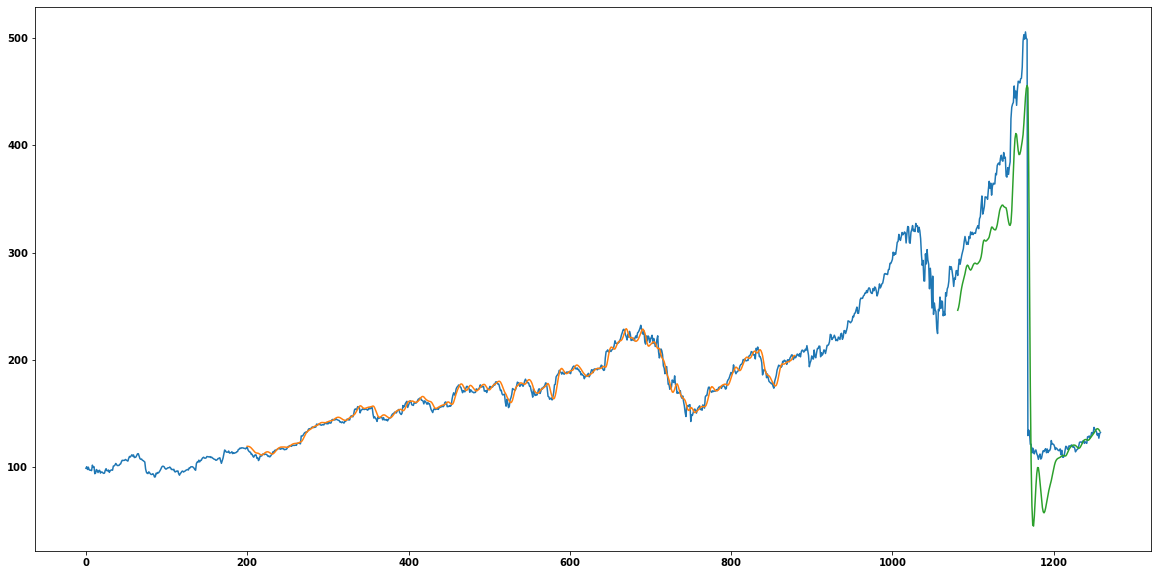

In [92]:
# shift train prediction for ploting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[200:len(train_predict)+200, :] = train_predict

# shift test prediction for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(200*2)+1:len(df)-1, :] = test_predict

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Predict future 100 days

In [62]:
len(test)

378

In [93]:
# take last 200 days from test data
x_input = test[178:].reshape(1,-1)

In [94]:
x_input.shape

(1, 200)

In [95]:
x_input

array([[0.40432952, 0.3785929 , 0.39559832, 0.39434756, 0.36216476,
        0.37183403, 0.36336741, 0.41402285, 0.40671076, 0.4226819 ,
        0.42730006, 0.43995189, 0.47314492, 0.46684305, 0.47227901,
        0.46292243, 0.44880337, 0.42821407, 0.44680698, 0.44423331,
        0.46333133, 0.46381239, 0.4527721 , 0.47478052, 0.48938064,
        0.47800361, 0.48784125, 0.49842453, 0.50580878, 0.51328924,
        0.52865905, 0.54039687, 0.53173782, 0.52269393, 0.52723993,
        0.52283824, 0.54027661, 0.53589898, 0.5505472 , 0.54482261,
        0.5497294 , 0.54453397, 0.54785328, 0.54819002, 0.54744438,
        0.55684907, 0.56043295, 0.56471437, 0.55797956, 0.58006013,
        0.5847745 , 0.61010222, 0.63138906, 0.59064342, 0.59761876,
        0.60769693, 0.62956103, 0.62838244, 0.62871918, 0.62388455,
        0.64589296, 0.6643175 , 0.64875526, 0.66025256, 0.63328924,
        0.65289236, 0.66015634, 0.65849669, 0.65849669, 0.68192423,
        0.6791341 , 0.70001203, 0.7039567 , 0.70

In [96]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [97]:
# prediction for the next 100 days

lst_output=[]
n_steps=200
i=0
while(i<100):
    
    if(len(temp_input)>200):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model2.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model2.predict(x_input, verbose=0)
#         print(yhat[0])
        temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

In [98]:
day_new=np.arange(1,201)
day_pred=np.arange(201,301)

In [99]:
len(df)

1259

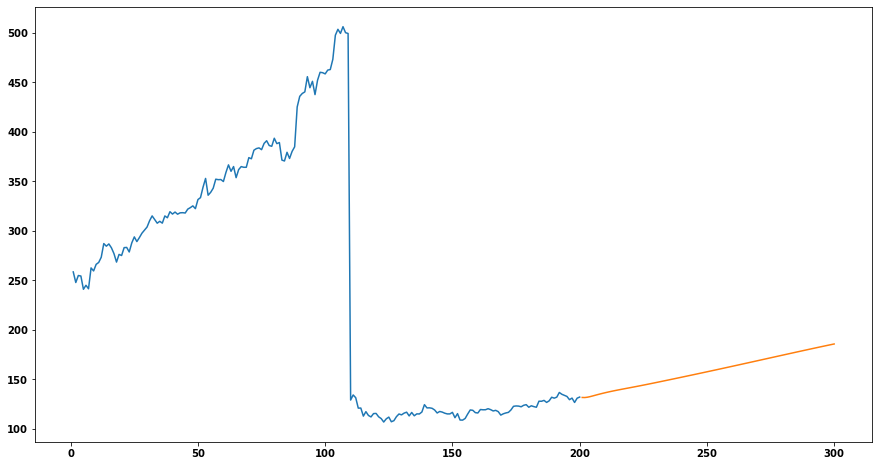

In [100]:
plt.figure(figsize=(15,8))
plt.plot(day_new,scaler.inverse_transform(df[1059:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

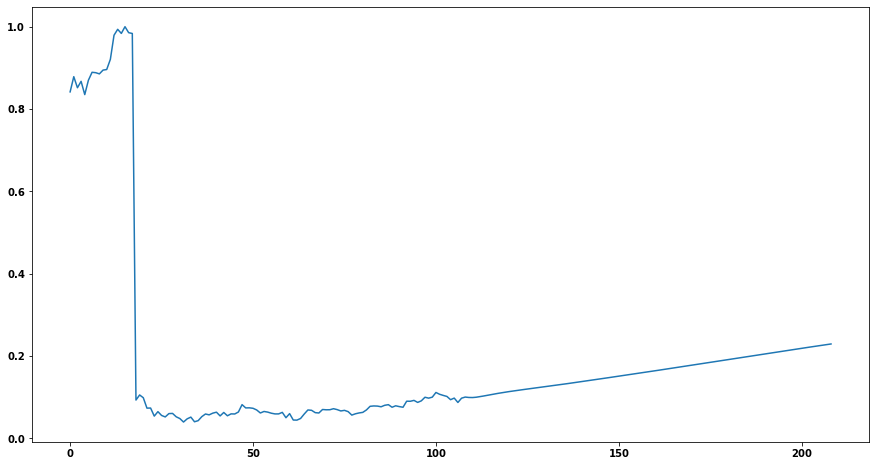

In [103]:
df3=df.tolist()
df3.extend(lst_output)
plt.figure(figsize=(15,8))
plt.plot(df3[1150:])